# Rules generation for diagnostic trouble code

Diagnostic trouble code is recorded once certain conditions happened on the car. These certain conditions can be curated as rules by the sensor manufactors. We can rely on it. 

### What if diagnostic trouble code sensor is not working at some point?
The curated rules don't seem transparent to us. If the sensor went wrong at some point, it may miss device issues, which leads to a potential risk on drivers safety. 

### Use machine learning to uncover the rules for diagnostic trouble code
In this notebook, I used diagnostic trouble code from on-board diagnostic system as the ground truth and built a XGBoost model to infer the rules behind a trouble code.

There are only 2 trouble codes in the data. Both of them happened when the car is idle (speed at 0). So in this notebook, we only use OBD signals and exclude accelerometer signals.

At the end, XGBoost presented an accurate rule for troubld code P00129. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

/opt/homebrew/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
car_df = pd.read_csv('clean_signals.csv')

car_df['timestamp'] = pd.to_datetime(car_df['timestamp'])

car_df.shape

(1953951, 18)

In [3]:
obd_sensors_cols = [
    'battery_volt', 'diagnostic_trouble_code', 
    'gps_speed', 'speed', 'kpl', 'revolutions_per_min', 
    'coolant_temp', 'intake_air_temp', 'timing_advance',
    'engine_load',  'imap', 'air_mass_rate', 'throttle_position',
]

acc_sensors_cols = [
    'acc_x', 'acc_y', 'acc_z'
]

In [4]:
X = car_df[obd_sensors_cols].drop('diagnostic_trouble_code', axis=1)
y = car_df['diagnostic_trouble_code'].values

### Diagnostic trouble code analysis

- P0129: Barometric pressure too low
- P0067: Air assisted injector -circuit high

[Trouble Code Reference](https://www.troublecodes.net/pcodes/)

In [5]:
car_df['diagnostic_trouble_code'].value_counts()

0      1953894
129         55
67           2
Name: diagnostic_trouble_code, dtype: int64

### Each trouble code only happened in 1 trip.

Both trouble codes happend when the car is idle (speed = 0). They are probably related to engine switching on.

It means accelerometer signals might not be meaningful in prediction these 2 trouble codes.

In [6]:
car_df[['device_id', 'trip_id', 'diagnostic_trouble_code']]\
    .drop_duplicates()\
    .reset_index()\
    .groupby('diagnostic_trouble_code')\
    .count()\
    .drop(['device_id', 'trip_id'], axis=1)\
    .rename(columns={'index': 'trip_count'})

,trip_count
diagnostic_trouble_code,
0,1539
67,1
129,1


In [7]:
def select_window_observation(df, index, start_steps, end_steps):
    """ In the same trip, select the neighour timestamps of a given index.
    """
    
    device_id, trip_id = df.loc[index][['device_id', 'trip_id']].values
    trip_index = df[(df['device_id'] == device_id) & (df['trip_id'] == trip_id)].index
    min_trip_index = trip_index.min()
    max_trip_index = trip_index.max()
    
    observation_start, observation_end = np.maximum(index - start_steps, min_trip_index), \
            np.minimum(index + end_steps, max_trip_index)
    observations = df.loc[observation_start:observation_end]
    
    return observations

In [8]:
error_code_index = car_df[car_df['diagnostic_trouble_code'] == 129].index.max()

select_window_observation(car_df, error_code_index, 3, 5)\
    [['device_id', 'trip_id', 'timestamp', 'diagnostic_trouble_code', 
      'imap', 'speed', 'engine_load', 'battery_volt']]

,device_id,trip_id,timestamp,diagnostic_trouble_code,imap,speed,engine_load,battery_volt
817056,7,103,2018-01-24 18:43:51,129,10,0,76.4706,12.8
817057,7,103,2018-01-24 18:43:52,129,10,0,76.4706,12.8
817058,7,103,2018-01-24 18:43:53,129,10,0,76.4706,12.8
817059,7,103,2018-01-24 18:43:55,129,10,0,76.4706,12.8
817060,7,103,2018-01-30 11:31:24,0,101,0,19.6078,0.0
817061,7,103,2018-01-30 11:31:26,0,101,0,20.0000,0.0
817062,7,103,2018-01-30 11:31:27,0,103,0,19.2157,0.0
817063,7,103,2018-01-30 11:31:28,0,103,0,12.9412,0.0
817064,7,103,2018-01-30 11:31:29,0,106,0,12.9412,0.0


In [9]:
error_code_index = car_df[car_df['diagnostic_trouble_code'] == 67].index.min()

select_window_observation(car_df, error_code_index, 3, 3)\
    [['device_id', 'trip_id', 'timestamp', 'diagnostic_trouble_code', 
      'imap', 'speed', 'engine_load', 'battery_volt']]

,device_id,trip_id,timestamp,diagnostic_trouble_code,imap,speed,engine_load,battery_volt
313158,3,83,2018-01-21 12:49:54,0,0,0,0.0000,0.0
313159,3,83,2018-01-21 12:49:55,0,0,0,0.0000,0.0
313160,3,83,2018-01-21 12:49:56,0,0,0,0.0000,0.0
313161,3,83,2018-01-21 12:49:57,67,0,0,0.0000,0.0
313162,3,83,2018-01-21 12:49:58,67,98,0,0.0000,0.0
313163,3,83,2018-01-21 12:49:59,0,98,0,18.0392,0.0
313164,3,83,2018-01-21 12:50:00,0,98,0,21.5686,0.0


### Surface the patterns behind trouble codes

In [10]:
def train_a_classifier(X, y):
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a classifier on the whole data set to learn patterns
    clf = XGBClassifier(n_estimators=100,
                     max_depth=4,
                     max_leaves=8,
                     eta=0.1,
                     reg_lambda=0,
                     tree_method='hist',
                     eval_metric='logloss',
                     use_label_encoder=False,
                     random_state=42,
                     n_jobs=-1)

#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    
    # Calculate recall score
    tp = sum((y == y_pred) & (y_pred==1))
    fn = sum((y != y_pred) & (y_pred==0))
    print("Recall: ", tp/(tp+fn))
    
    # Plot confusion matrix
    fig = plt.figure()
    labels = sorted(list(set(y)))
    c_m = confusion_matrix(y, y_pred)
    sns.heatmap(c_m, xticklabels=labels, yticklabels=labels, annot=True, 
                linewidths = 0.1, fmt="d", cmap = "YlGnBu")
    plt.title("Confusion matrix", fontsize = 15)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    confusion_matrix_plot = fig
    
    # Plot feature importance
    fig = plt.figure()
    sorted_idx = clf.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], 
             clf.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance")
    feature_importance_plot = fig
    
    # Plot decision process in XGBoost
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(24, 32))
    plot_tree(clf, ax=ax)
    rules_plot = fig
    
    return confusion_matrix_plot, feature_importance_plot, rules_plot

In [11]:
def surface_patterns(df, target_code):
    
    # Could use SMOTE for upsampling. 
#     df = df.append([df[df['diagnostic_trouble_code'] == target_code]],
#                    ignore_index=True)

    target_index = df['diagnostic_trouble_code'].isin([0, target_code])
    
    X = df[target_index][obd_sensors_cols]\
        .drop('diagnostic_trouble_code', axis=1).copy()
    
    y = df[target_index]['diagnostic_trouble_code'].values.copy()
    
    y[y == target_code] = 1

    confusion_matrix_plot, feature_importance_plot, rules_plot = train_a_classifier(X, y)
    
    return confusion_matrix_plot, feature_importance_plot, rules_plot

/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Recall:  1.0


(<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 1728x2304 with 1 Axes>)

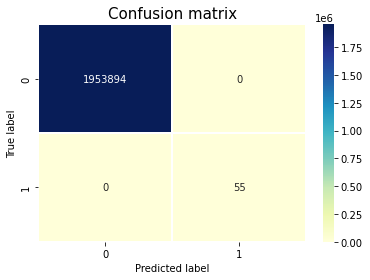

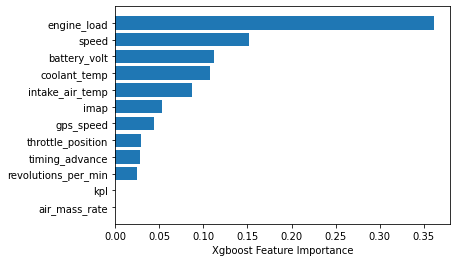

<Figure size 432x288 with 0 Axes>

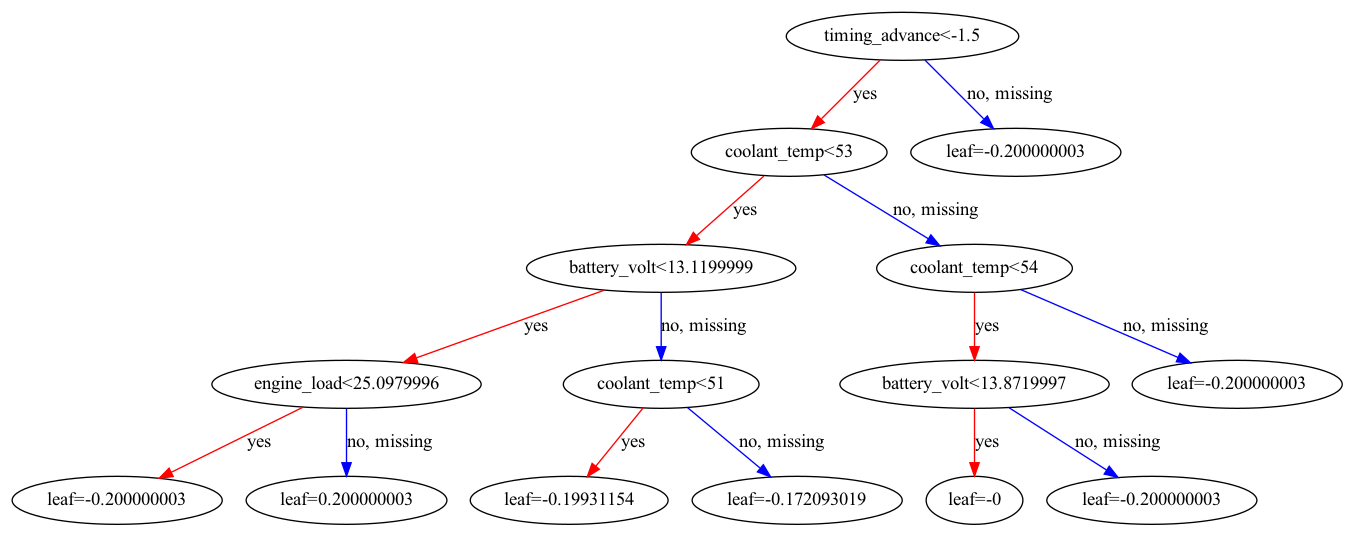

In [12]:
surface_patterns(car_df, 129)

### Tree Interpretation
The values on leaves are logits the model outputs. We need to convert them into probabilities using sigmoid function.

1. Traverse the tree from the root to its left (engine_load < 25.09).
2. `-0.2` logit equals to `45%`. It means with this rule, the model thinks the probability of having a 129 trouble code is 45%.  
3. On the other hand, **it means there is 55% probability that this rule can help us find 129 trouble code.**
4. Given that our model's recall is 100%, it's able to predict all trouble code 129 related samples.
5. **It means this rule example can 100% find 129 trouble code in the data.**

In [13]:
1/(1+np.exp(-1*-0.2)), 1/(1+np.exp(-1*0.2))

(0.45016600268752216, 0.549833997312478)

### Using this rule to filter the data, we can find all the results are associated with 129. 
**It tells the trouble code P0129 is very much related to these 4 sensor signals.**
- timing advance
- coolant temperature
- battery volt
- engine load

In [15]:
rule_example_for_code_P0129 = (car_df['timing_advance'] < -1.5) & (car_df['coolant_temp'] < 53) & \
                     (car_df['battery_volt'] < 13.1199999) & (car_df['engine_load'] > 25.0979996)

car_df.loc[rule_example_for_code_P0129]

,device_id,trip_id,timestamp,battery_volt,diagnostic_trouble_code,gps_speed,speed,kpl,revolutions_per_min,coolant_temp,intake_air_temp,timing_advance,engine_load,imap,air_mass_rate,throttle_position,accelerometer,is_complete
817017,7,103,2018-01-24 18:43:02,13.08,129,0.0,0,0.0,0.0,52,27,-2.0,76.4706,10,0.0,18.4314,044801c004d801e73d00e73d00e63b00e63d01e73b00e7...,False
817018,7,103,2018-01-24 18:43:03,13.10,129,0.0,0,0.0,0.0,52,27,-2.0,76.4706,10,0.0,18.4314,046801b004f8ffe83cffe83900e63c00e93cffe73b00e6...,False
817019,7,103,2018-01-24 18:43:04,13.10,129,0.0,0,0.0,0.0,52,27,-2.0,76.4706,10,0.0,18.4314,047801d804e801e43d01e63d01e43cffe73a00e63d01e6...,False
817020,7,103,2018-01-24 18:43:06,13.08,129,0.0,0,0.0,0.0,51,27,-2.0,76.4706,10,0.0,18.4314,046001d00508ffea3b01e63d00e73d00e53c01e73d00e8...,False
817021,7,103,2018-01-24 18:43:07,13.06,129,0.0,0,0.0,0.0,51,27,-2.0,76.4706,10,0.0,18.4314,042001d0051800e63a01e73effe73d00e73a01e53e00e6...,False
817022,7,103,2018-01-24 18:43:08,13.06,129,0.0,0,0.0,0.0,51,27,-2.0,76.4706,10,0.0,18.4314,045001c0052800e63c01e43d00e73d00e53a00e83e00e7...,False
817023,7,103,2018-01-24 18:43:09,12.88,129,0.0,0,0.0,0.0,50,27,-2.0,76.4706,10,0.0,15.6863,048001c004e800e73c01e43d00e53c00e83c02e73d01e6...,False
817024,7,103,2018-01-24 18:43:10,12.84,129,0.0,0,0.0,0.0,50,27,-2.0,76.4706,10,0.0,15.6863,044801e80528ffe73affe63c00e73c01e63d00e73cffe8...,False
817025,7,103,2018-01-24 18:43:11,12.94,129,0.0,0,0.0,0.0,50,27,-2.0,76.4706,10,0.0,15.6863,043001c004d000e53d01e63c01e43c01e53e01e73b00e6...,False
817026,7,103,2018-01-24 18:43:12,12.94,129,0.0,0,0.0,0.0,50,27,-2.0,76.4706,10,0.0,15.6863,04c001c8050002e63c01e53c00e63c00e63b00e73c00e5...,False


### We can hardly learn patterns for trouble code 67. Because there are only 2 related samples. 

/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Recall:  0.0


(<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 1728x2304 with 1 Axes>)

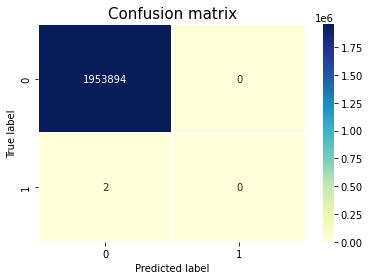

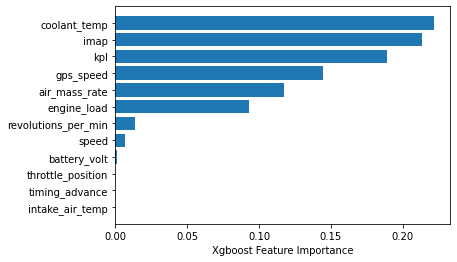

<Figure size 432x288 with 0 Axes>

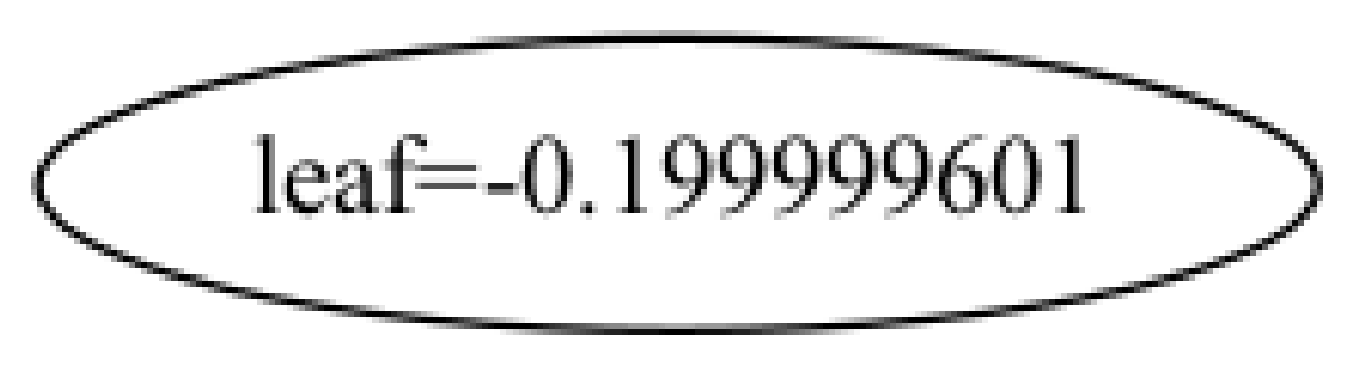

In [16]:
surface_patterns(car_df, 67)